# 📸 Image Similarity Search - Full Project Demo

Welcome! This notebook contains the **entire logic** for the Image Similarity Project in one place.
You don't need to run any external scripts - we'll define everything right here! 🚀

## What we'll do:
1. **Setup**: Import libraries and define helper functions.
2. **Data**: Download a demo dataset of cats and dogs.
3. **Model**: Load a state-of-the-art Hugging Face model (`SigLIP`).
4. **Index**: Turn our images into mathematical vectors (embeddings).
5. **Search**: Find the most similar images to a query!

Let's get started! 👇

In [1]:
# 1. Imports
import torch
from transformers import AutoProcessor, AutoModel
from PIL import Image
import numpy as np
import os
import pickle
from pathlib import Path
import requests
from io import BytesIO
from tqdm.notebook import tqdm # Use notebook-friendly progress bar
from IPython.display import display, HTML

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE} (Running fast? {'Yes ⚡' if DEVICE == 'cuda' else 'No 🐢'})")

Using device: cpu (Running fast? No 🐢)


## 2. Utility Functions 🛠️
These functions handle the heavy lifting: loading the AI model and converting images to embeddings.

In [2]:
def load_model(model_name="google/siglip-base-patch16-224"):
    """
    Loads the model and processor from Hugging Face.
    """
    print(f"Loading model: {model_name} ...")
    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(DEVICE)
    model.eval()
    return model, processor

def compute_image_embedding(image_path, model, processor):
    """
    Reads an image and returns its normalized embedding.
    """
    if isinstance(image_path, str):
        image_path = Path(image_path)

    if not image_path.exists():
        return None

    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            # Get features. Works for SigLIP and CLIP.
            if hasattr(model, 'get_image_features'):
                outputs = model.get_image_features(**inputs)
            else:
                outputs = model.get_text_features(**inputs)

        # Normalize (L2) - Vital for Cosine Similarity!
        embedding = outputs / outputs.norm(p=2, dim=-1, keepdim=True)
        return embedding.cpu().numpy().flatten()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

## 3. Prepare Data 💾
We need some images to search! I'll download a few demo images if you don't have them.

In [3]:
DEMO_IMAGES = {
    "cat_1.jpg": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=600",
    "cat_2.jpg": "https://images.unsplash.com/photo-1573865526739-10659fec78a5?w=600",
    "cat_3.jpg": "https://images.unsplash.com/photo-1495360019602-e05980bf5490?w=600",
    "dog_1.jpg": "https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=600",
    "dog_2.jpg": "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=600",
    "dog_3.jpg": "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=600",
    "car_1.jpg": "https://images.unsplash.com/photo-1568605117036-5fe5e7bab0b7?w=600",
}

def setup_data():
    dest_dir = Path("dataset_images")
    dest_dir.mkdir(exist_ok=True)

    print(f"Checking for images in {dest_dir}...")
    for name, url in tqdm(DEMO_IMAGES.items()):
        if not (dest_dir / name).exists():
            try:
                resp = requests.get(url, timeout=10)
                img = Image.open(BytesIO(resp.content))
                img.save(dest_dir / name)
            except Exception as e:
                print(f"Failed to download {name}: {e}")
    print("Data ready! 📸")

setup_data()

Checking for images in dataset_images...


  0%|          | 0/7 [00:00<?, ?it/s]

Failed to download cat_3.jpg: cannot identify image file <_io.BytesIO object at 0x7d2fa1f3e5c0>
Data ready! 📸


## 4. Indexing Workflow 🏗️
Now we generate embeddings for all our images and store them in memory (and save to disk).

In [4]:
# Load Model
model, processor = load_model()

# Find images
dataset_path = Path("dataset_images")
valid_exts = {'.jpg', '.png', '.jpeg', '.webp'}
all_files = [p for p in dataset_path.rglob("*") if p.suffix.lower() in valid_exts]

embeddings = []
filenames = []

print(f"Indexing {len(all_files)} images...")

# Compute loop
for image_file in tqdm(all_files):
    emb = compute_image_embedding(image_file, model, processor)
    if emb is not None:
        embeddings.append(emb)
        filenames.append(str(image_file.name))

# Convert to matrix
index_embeddings = np.vstack(embeddings).astype('float32')
print(f"Index shape: {index_embeddings.shape}")

Loading model: google/siglip-base-patch16-224 ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Indexing 6 images...


  0%|          | 0/6 [00:00<?, ?it/s]

Index shape: (6, 768)


## 5. Search Time! 🕵️‍♀️
Pick a query image and let's find its twins based on visual similarity.

Query Image: dog_1.jpg


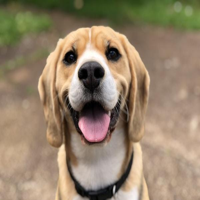

In [5]:
# Choose a query image (Change the index to swap query!)
query_idx = 3  # Try 0 for cat, 3 for dog
query_filename = filenames[query_idx]
query_path = dataset_path / query_filename

print(f"Query Image: {query_filename}")
display(Image.open(query_path).resize((200, 200)))

--- Top 3 Matches ---


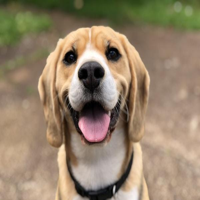

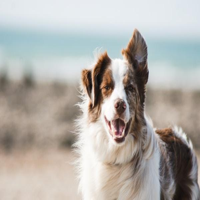

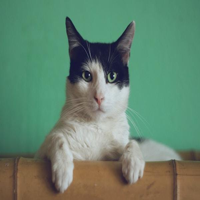

In [6]:
# 1. Compute embedding for query
query_emb = compute_image_embedding(query_path, model, processor)

# 2. Cosine Similarity (Dot product of normalized vectors)
scores = np.dot(index_embeddings, query_emb)

# 3. Sort results (highest score first)
top_k = 3
top_indices = np.argsort(scores)[::-1][:top_k]

print(f"--- Top {top_k} Matches ---")

for i, idx in enumerate(top_indices):
    fname = filenames[idx]
    score = scores[idx]

    # Display result using HTML for side-by-side feel
    display(HTML(f"<b>Reference #{i+1}: {fname}</b> (Score: {score:.4f})"))
    filepath = dataset_path / fname
    display(Image.open(filepath).resize((200, 200)))